In [ ]:
# !pip install transformers
from transformers import pipeline
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


GPU is available


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/100k.csv')
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/PLP.csv')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/160k.csv')
df['body'] = df['body'].astype(str)

Mounted at /content/drive


In [ ]:
########### using sentiment analysis model

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device = 0)
# List to store the results
results = []
def truncate_to_max_length(text, max_length):
    encoded_input = tokenizer(text, truncation=True, max_length=max_length, return_tensors='pt')
    return tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True)

for index, row in tqdm(df.iterrows(), total=len(df), ncols=100):
    review = row['body']
    subreddit = row['subreddit']
    created_utc = row['created_utc']


    # Sentence tokenization
    for sentence in sent_tokenize(review):
        truncated_sentence = truncate_to_max_length(sentence, max_length=512)
        # Get sentiment for the sentence
        sentiment_result = sentiment_analyzer(truncated_sentence)[0]

        # Extract sentiment label and score
        sentiment_label = sentiment_result['label']
        sentiment_score = sentiment_result['score']

        # Append results
        results.append({
            "subreddit": subreddit,
            "created_utc": created_utc,
            "sentence": sentence,
            "sentiment": sentiment_label,
            "sentiment_score": sentiment_score
        })

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████| 161552/161552 [50:29<00:00, 53.32it/s]


In [ ]:
sentiment_df = pd.DataFrame(results)
threshold = 0.7
sentiment_df.loc[sentiment_df['sentiment_score'] < threshold, 'sentiment'] = 'NEUTRAL'
sentiment_df.to_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/sentiment_analysis_results_distilbert_160k.csv', index=False)
print("Sentiment analysis results saved")

Sentiment analysis results saved


In [4]:
# sentiment_df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/sentiment_analysis_results_distilbert_160k.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


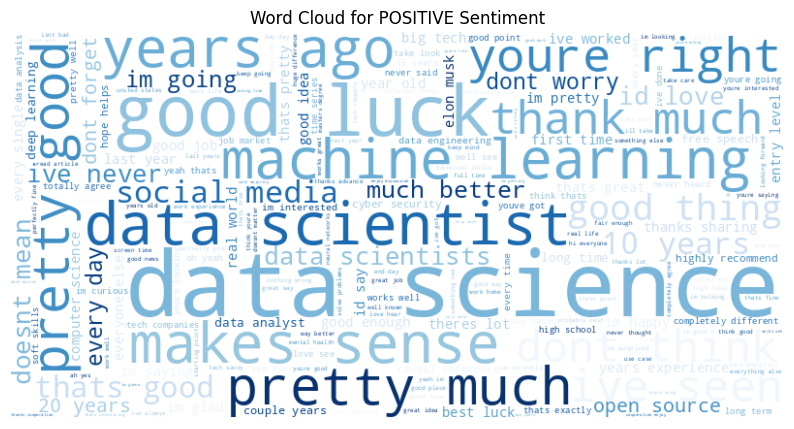

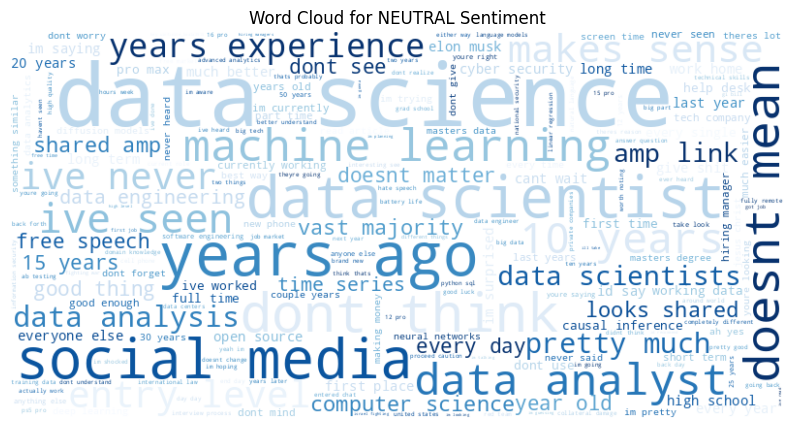

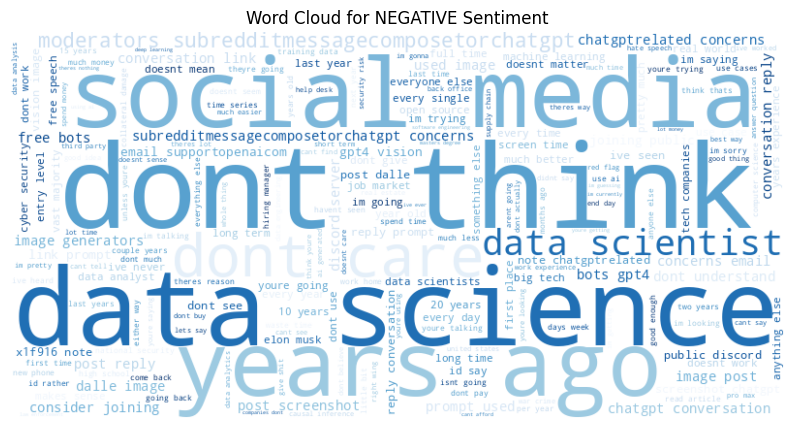

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
# Assuming sentiment_df is your DataFrame with a 'sentence' column

# List of additional stopwords
add_stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
                      'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
                      'himself', 'she', 'her', 'hers', 'herself', 'it', 'its',
                      'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                      'what', 'which', 'who', 'whom', 'this', 'that', 'these',
                      'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
                      'being', 'have', 'has', 'had', 'having', 'do', 'does',
                      'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
                      'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
                      'with', 'about', 'against', 'between', 'into', 'through',
                      'during', 'before', 'after', 'above', 'below', 'to', 'from',
                      'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
                      'again', 'further', 'then', 'once', 'here', 'there',
                      'when', 'where', 'why', 'how', 'all', 'any', 'both',
                      'each', 'few', 'more', 'most', 'other', 'some', 'such',
                      'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
                      'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
                      'should', 'now', "i'll", "you'll", "he'll", "she'll",
                      "we'll", "they'll", "i'd", "you'd", "he'd", "she'd",
                      "we'd", "they'd", "i'm", "you're", "he's", "she's",
                      "it's", "we're", "they're", "i've", "we've", "you've",
                      "they've", "isn't", "aren't", "wasn't", "weren't",
                      "haven't", "hasn't", "hadn't", "don't", "doesn't",
                      "didn't", "won't", "wouldn't", "shan't", "shouldn't",
                      "mustn't", "can't", "couldn't", 'cannot', 'could',
                      "here's", "how's", "let's", 'ought', "that's",
                      "there's", "what's", "when's", "where's", "who's",
                      "why's", 'would', 'i', 'we', 'he', 'she', 'is',
                      'like', 'and', 'the', 'want', 'really', 'u', 'go',
                      's', 'still', 'sounds', 'like', 'make', 'sure',
                      'feel', 'maybe', 'need', 'bot', 'action', 'performed',
                      'automatically', 'please', 'contact', 'message',
                      'compose', 'questions', 'even', 'though', 'many',
                      'one', 'someone', 'people', 'get', 'also', 'us',
                      'might', 'let', 'know']

# Get the stopwords list
stopwords_list = stopwords.words('english') + add_stopwords_list
# Ensure sentiment_df has the 'sentence' column and preprocess it
sentiment_df['sentence'] = sentiment_df['sentence'].astype(str)
# Assuming sentiment_df has a 'sentence' column with the text data
# Remove http tags (if applicable)
sentiment_df['sentence'] = sentiment_df['sentence'].replace(r'http\S+', '', regex=True)
# Convert to lowercase
sentiment_df['sentence'] = sentiment_df['sentence'].str.lower()
# Remove punctuation
sentiment_df['sentence'] = sentiment_df['sentence'].str.replace('[^\w\s]', '', regex=True)
# Remove stopwords
sentiment_df['sentence'] = sentiment_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))
def generate_wordcloud(df, sentiment):
    # Filter the DataFrame for the specified sentiment
    filtered_df = df[df['sentiment'] == sentiment]

    # Create bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords_list)
    bigram_counts = vectorizer.fit_transform(filtered_df['sentence'])

    # Get bigram frequencies
    feature_names = vectorizer.get_feature_names_out()
    bigram_freq = dict(zip(feature_names, bigram_counts.sum(axis=0).tolist()[0]))

    # Create WordCloud from the bigram frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(bigram_freq)

    # Plot the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment category
for sentiment in ['POSITIVE', 'NEUTRAL', 'NEGATIVE']:
    generate_wordcloud(sentiment_df, sentiment)